In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
from fastbook import *
from utils import *
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.metrics import accuracy_score, roc_auc_score 
import datetime


path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 200
pd.options.display.max_columns = 120

## Data processing steps

### Assign order to ordinals

There does not appear to be any identifiable ordinal variables amoung the catergorical variables in the dataset.

### Handling dates

The only place where there is datetime info is the TransactionDT collumn. It's possible to turn this delta into a datetime (assuming units are seconds as indicated by some on the disscussion board) by choosing a starting point. [example](https://www.kaggle.com/nroman/eda-for-cis-fraud-detection). I will train my first models without doing that.

Next need to add datepart (i think it's important for parts of this that the correct start date is used)

The work in the kernal [here](https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature), indicates that time of day in particular could be a useful feature. 

In [19]:
train_ss = pd.read_csv(path/'train_ss.csv', index_col=[0], low_memory=False)

(0.0, 200.0)

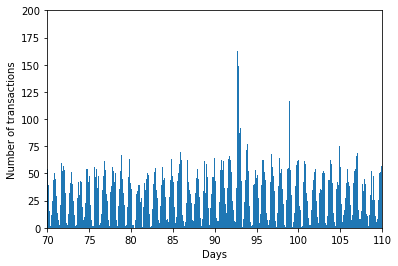

In [20]:
plt.hist(train_ss['TransactionDT'] / (3600*24), bins=1800)
plt.xlim(70, 78 + 32)
plt.xlabel('Days')
plt.ylabel('Number of transactions')
plt.ylim(0,200)

In [21]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
dep_var = 'isFraud'
cut_off = math.floor((train_ss['TransactionDT'].max() - train_ss['TransactionDT'].min())*0.8)
cut_off

cond = train_ss['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [22]:
START_DATE = '2017-12-01'

The choice of start date is supported by the finding that (see the EDA notebook) there are spikes in the number of transactions around the begining of the data set and again around 1 year later.

In [23]:
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
train_ss['TransactionDT'] = train_ss['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

In [24]:
train_ss['TransactionDT']

57195    2017-12-16 05:39:01
312877   2018-03-01 01:09:36
195195   2018-01-20 20:45:17
21600    2017-12-07 15:01:58
12253    2017-12-05 00:43:01
                 ...        
224165   2018-01-31 01:53:24
322952   2018-03-03 17:49:52
449491   2018-04-12 17:07:47
343893   2018-03-09 00:59:18
125898   2017-12-29 20:45:22
Name: TransactionDT, Length: 59054, dtype: datetime64[ns]

In [25]:
train_ss = add_datepart(train_ss, 'TransactionDT', drop=False, time=True)

In [45]:
train_ss.head()

,TransactionID,isFraud,TransactionDT,TransactionDTWeek,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed
57195,3044195,0,2017-12-16 05:39:01,50,418.95,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,aol.com,NaN,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,NaN,463.0,288.0,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,16,5,350,False,False,False,False,False,False,5,39,1,1513402741
312877,3299877,0,2018-03-01 01:09:36,9,59.00,W,12577,268.0,150.0,visa,166.0,debit,325.0,87.0,4.0,NaN,gmail.com,NaN,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,NaN,NaN,330.0,196.0,NaN,NaN,NaN,NaN,400.0,301.0,NaN,NaN,NaN,330.0,T,T,T,M0,F,T,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,3,1,3,60,False,True,False,False,False,False,1,9,36,1519866576
195195,3182195,1,2018-01-20 20:45:17,3,29.00,W,4693,417.0,150.0,visa,195.0,debit,308.0,87.0,1.0,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,NaN,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,51.0,T,T,T,M0,T,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,20,5,20,False,False,False,False,False,False,20,45,17,1516481117
21600,3008600,0,2017-12-07 15:01:58,49,24.00,W,7919,194.0,150.0,mastercard,202.0,debit,123.0,87.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M1,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,7,3,341,False,False,False,False,False,False,15,1,58,1512658918
12253,2999253,0,2017-12-05 00:43:01,49,57.95,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,27.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,1,339,False,False,False,False,False,False,0,43,1,1512434581


In [36]:
train_ss.to_csv(path/'train_ss_01.csv')

### Split TransactionAmt (with datetime handling above)

In [223]:
train_ss['TransactionAmt']

57195     418.950
312877     59.000
195195     29.000
21600      24.000
12253      57.950
           ...   
224165     28.018
322952    123.498
449491     59.000
343893     31.902
125898     54.500
Name: TransactionAmt, Length: 59054, dtype: float64

In [200]:
# train_ss['TransactionAmt'] = np.log(train_ss['TransactionAmt'])

In [47]:
train_ss.head()

,TransactionID,isFraud,TransactionDT,TransactionDTWeek,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionDTYear,TransactionDTMonth,TransactionDTDay,TransactionDTDayofweek,TransactionDTDayofyear,TransactionDTIs_month_end,TransactionDTIs_month_start,TransactionDTIs_quarter_end,TransactionDTIs_quarter_start,TransactionDTIs_year_end,TransactionDTIs_year_start,TransactionDTHour,TransactionDTMinute,TransactionDTSecond,TransactionDTElapsed
57195,3044195,0,2017-12-16 05:39:01,50,418.95,W,4806,490.0,150.0,visa,226.0,debit,315.0,87.0,NaN,NaN,aol.com,NaN,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,472.0,NaN,463.0,288.0,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,288.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,16,5,350,False,False,False,False,False,False,5,39,1,1513402741
312877,3299877,0,2018-03-01 01:09:36,9,59.00,W,12577,268.0,150.0,visa,166.0,debit,325.0,87.0,4.0,NaN,gmail.com,NaN,5.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,12.0,4.0,0.0,NaN,NaN,330.0,196.0,NaN,NaN,NaN,NaN,400.0,301.0,NaN,NaN,NaN,330.0,T,T,T,M0,F,T,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,3,1,3,60,False,True,False,False,False,False,1,9,36,1519866576
195195,3182195,1,2018-01-20 20:45:17,3,29.00,W,4693,417.0,150.0,visa,195.0,debit,308.0,87.0,1.0,NaN,yahoo.com,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,8.0,1.0,51.0,51.0,0.0,51.0,0.0,NaN,NaN,NaN,NaN,51.0,51.0,NaN,NaN,NaN,51.0,T,T,T,M0,T,F,F,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,20,5,20,False,False,False,False,False,False,20,45,17,1516481117
21600,3008600,0,2017-12-07 15:01:58,49,24.00,W,7919,194.0,150.0,mastercard,202.0,debit,123.0,87.0,0.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,T,M1,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,7,3,341,False,False,False,False,False,False,15,1,58,1512658918
12253,2999253,0,2017-12-05 00:43:01,49,57.95,W,13108,215.0,150.0,visa,226.0,debit,191.0,87.0,27.0,NaN,NaN,NaN,2.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,0.0,3.0,0.0,18.0,2.0,484.0,484.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,483.0,NaN,NaN,NaN,NaN,NaN,T,T,T,NaN,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,12,5,1,339,False,False,False,False,False,False,0,43,1,1512434581


In [93]:
train_ss['TransactionAmtCents'] = ((train_ss['TransactionAmt'] - train_ss['TransactionAmt'].astype(int)) * 1000)
train_ss['TransactionAmtdDollars'] = train_ss['TransactionAmt'].astype(int)
train_ss.drop(columns='TransactionAmt', axis=1, inplace=True)

In [95]:
train_ss.to_csv(path/'train_ss_02.csv')

### Transforming D features

### Label Encode

"Label encoding (factorizing) converts a (string, category, object) column to integers. Afterward you can cast it to int8, int16, or int32 depending on whether max is less than 128, less than 32768, or not. Factorizing reduces memory and turns NAN into a number (i.e. -1) which affects CV and LB as described above. Factorizing also gives you the choice to treat categorical variable as numeric described below."

Fastai does all this when I call TabularPandas